In [3]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
data = pd.read_csv('../data/raw/haaland_shot_map.csv')


In [4]:
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Select relevant features and target
features = ['X', 'Y', 'shotType', 'lastAction', 'situation']
target = 'xG'
data = data[features + [target]].dropna()  # Drop rows with missing values

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['X', 'Y']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['shotType', 'lastAction', 'situation'])
    ]
)

X = data[features]
y = data[target]

# Transform features
X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


# Define the neural network model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mse = nn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test MSE: {mse}")

y_pred = nn_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Define a function to predict xG for new inputs
def predict_xg(x, y, shot_type, last_action, situation):
    input_data = pd.DataFrame([[x, y, shot_type, last_action, situation]], columns=['X', 'Y', 'shotType', 'lastAction', 'situation'])
    input_processed = preprocessor.transform(input_data)
    predicted_xg = nn_model.predict(input_processed)
    return predicted_xg[0][0]

D:\sem6\thesis\data_collection\football\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.018

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0204 - mse: 0.0204
Test Loss: 0.0191, Test MSE: 0.0191
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
R² Score: 0.6063


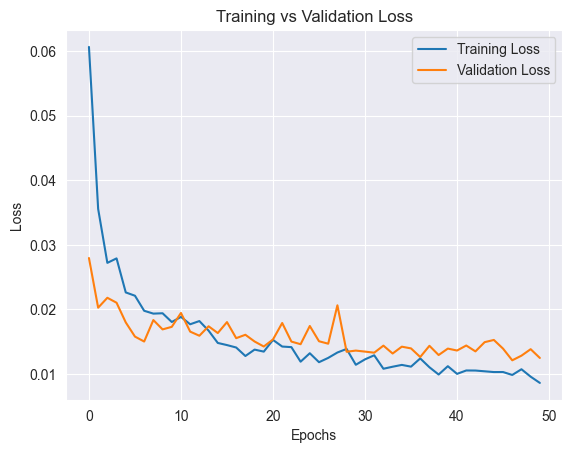

In [5]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Evaluate the model
loss, mse = nn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MSE: {mse:.4f}")

# Calculate R² Score
y_pred = nn_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [6]:
import pickle

# Bundle the model and preprocessor
model_preprocessor_bundle = {
    'model': nn_model,
    'preprocessor': preprocessor
}

# Save to a pickle file
file_path = '../data/model/nn_model_and_preprocessor.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model_preprocessor_bundle, file)

print(f"Model and preprocessor saved to {file_path}")


Model and preprocessor saved to ../data/model/nn_model_and_preprocessor.pkl


In [7]:
example_xg = predict_xg(0.95, 0.500, 'LeftFoot', 'HeadPass', 'FromCorner')
print(f"Predicted xG: {example_xg:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted xG: 0.4364


In [8]:
import pickle

# Load the model
with open("../data/model/nn_model_and_preprocessor.pkl", "rb") as file:
    loaded_model = pickle.load(file)
nn_model = loaded_model['model']
# Use the loaded model for predictions
predictions = nn_model.predict(X_test)
print(predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
[[0.09523745]
 [0.7158219 ]
 [0.11345199]
 [0.18023685]
 [0.5403711 ]
 [0.23404261]
 [0.0647389 ]
 [0.20212376]
 [0.369242  ]
 [0.22179791]
 [0.05139665]
 [0.28270048]
 [0.12322845]
 [0.11025786]
 [0.06629114]
 [0.08549276]
 [0.06046045]
 [0.06661724]
 [0.53758925]
 [0.10788285]
 [0.13754094]
 [0.19424093]
 [0.18415129]
 [0.3899817 ]
 [0.73931897]
 [0.02499397]
 [0.10011832]
 [0.18783435]
 [0.6799892 ]
 [0.28857747]
 [0.73931897]
 [0.13922468]
 [0.15723357]
 [0.20621037]
 [0.73931897]
 [0.2737455 ]
 [0.10595049]
 [0.10281056]
 [0.02430046]
 [0.33686778]
 [0.27050382]
 [0.5655925 ]
 [0.73931897]
 [0.36098826]
 [0.717142  ]
 [0.32684594]
 [0.2363146 ]
 [0.31100568]
 [0.09143572]
 [0.16271192]
 [0.04695034]
 [0.09805208]
 [0.13400152]
 [0.12266236]
 [0.07349817]
 [0.28624097]
 [0.44405082]
 [0.04821917]
 [0.09337262]
 [0.07506122]
 [0.44897273]
 [0.11217682]
 [0.27821797]
 [0.36785772]
 [0.20641685]
 [0.15384349]
 [0.04668694]
 [0.3479379 ]
 [0.07675

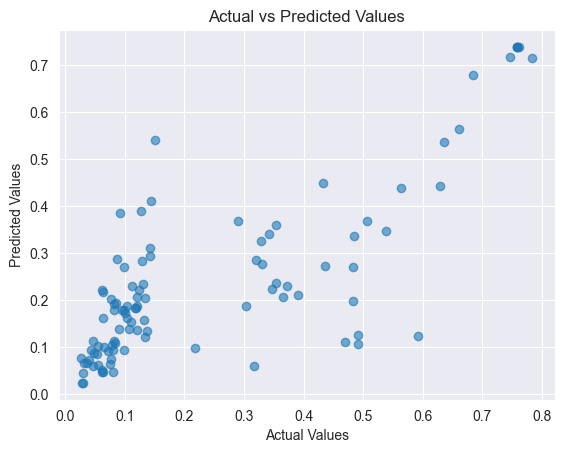

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


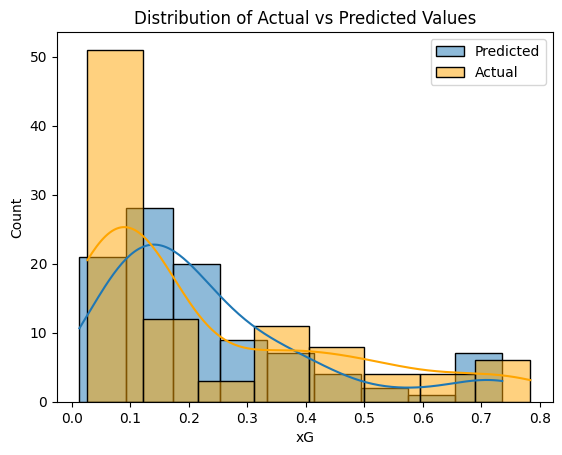

In [12]:
import seaborn as sns

sns.histplot(predictions, kde=True, color="blue", label="Predicted")
sns.histplot(y_test, kde=True, color="orange", label="Actual")
plt.legend()
plt.title("Distribution of Actual vs Predicted Values")
plt.show()


In [15]:
# Ensure y_test is 1D
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

# Ensure predictions are 1D
if len(predictions.shape) > 1:
    predictions = predictions.flatten()


In [16]:
residuals = y_test - predictions


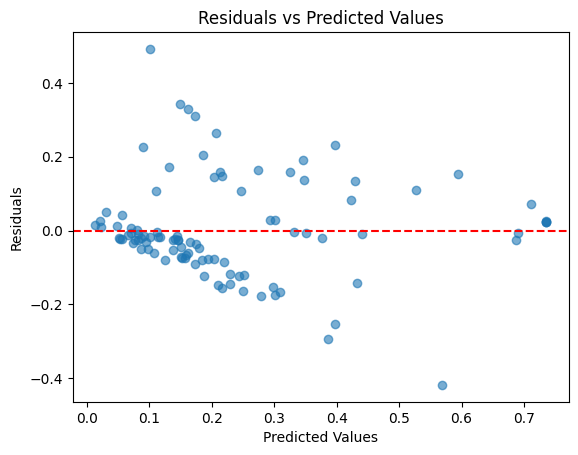

In [17]:
import matplotlib.pyplot as plt

plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


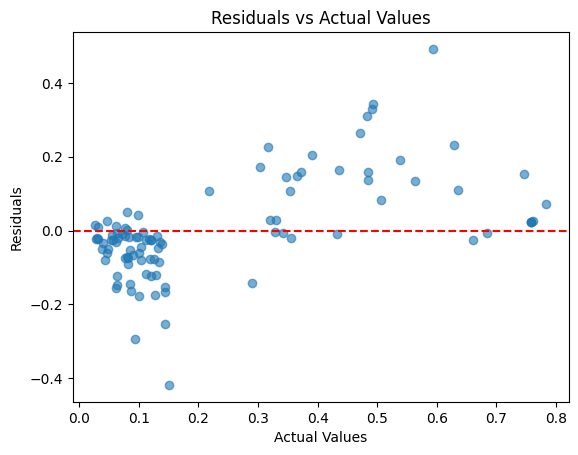

In [18]:
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Values")
plt.show()
